In [1]:
# Import our dependencies
import pandas as pd
import numpy as np
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
import seaborn as sns
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
# load password
from config import db_password
# Assign connection values
url = "sirt-moviesdb.cwrtp1de0qsq.ca-central-1.rds.amazonaws.com"
port = "5432"
db_name = "postgres"

In [3]:
# Connect to the AWS database
from sqlalchemy import create_engine
db_string = f"postgresql://sirtmovie:{db_password}@{url}:{port}/{db_name}"
engine = create_engine(db_string)
conn = engine.connect()

In [4]:
# read rating values
df1 = pd.read_sql('SELECT * FROM "rating"', conn)
df1.head()

,movie_id,movie_title,director_name,num_voted_users,num_critic_for_reviews,imdb_score,movie_imdb_link
0,M001,Avatar¬†,James Cameron,886204,723.0,7.9,http://www.imdb.com/title/tt0499549/?ref_=fn_t...
1,M002,Pirates of the Caribbean: At World's End¬†,Gore Verbinski,471220,302.0,7.1,http://www.imdb.com/title/tt0449088/?ref_=fn_t...
2,M003,Spectre¬†,Sam Mendes,275868,602.0,6.8,http://www.imdb.com/title/tt2379713/?ref_=fn_t...
3,M004,The Dark Knight Rises¬†,Christopher Nolan,1144337,813.0,8.5,http://www.imdb.com/title/tt1345836/?ref_=fn_t...
4,M005,Star Wars: Episode VII - The Force Awakens¬† ...,Doug Walker,8,NaN,7.1,http://www.imdb.com/title/tt5289954/?ref_=fn_t...


In [5]:
# read boxoffice values
df2 = pd.read_sql('SELECT * FROM "boxoffice"', conn)
df2.head()

,movie_id,budget,gross
0,M001,237000000.0,760505847.0
1,M002,300000000.0,309404152.0
2,M003,245000000.0,200074175.0
3,M004,250000000.0,448130642.0
4,M005,NaN,NaN


In [6]:
df3 = pd.merge(df1, df2, on='movie_id')
df3.head()

,movie_id,movie_title,director_name,num_voted_users,num_critic_for_reviews,imdb_score,movie_imdb_link,budget,gross
0,M001,Avatar¬†,James Cameron,886204,723.0,7.9,http://www.imdb.com/title/tt0499549/?ref_=fn_t...,237000000.0,760505847.0
1,M002,Pirates of the Caribbean: At World's End¬†,Gore Verbinski,471220,302.0,7.1,http://www.imdb.com/title/tt0449088/?ref_=fn_t...,300000000.0,309404152.0
2,M003,Spectre¬†,Sam Mendes,275868,602.0,6.8,http://www.imdb.com/title/tt2379713/?ref_=fn_t...,245000000.0,200074175.0
3,M004,The Dark Knight Rises¬†,Christopher Nolan,1144337,813.0,8.5,http://www.imdb.com/title/tt1345836/?ref_=fn_t...,250000000.0,448130642.0
4,M005,Star Wars: Episode VII - The Force Awakens¬† ...,Doug Walker,8,NaN,7.1,http://www.imdb.com/title/tt5289954/?ref_=fn_t...,NaN,NaN


# Data Preprocessing

In [7]:
df3.columns

Index(['movie_id', 'movie_title', 'director_name', 'num_voted_users',
       'num_critic_for_reviews', 'imdb_score', 'movie_imdb_link', 'budget',
       'gross'],
      dtype='object')

In [8]:
# select the revelant columns
moviedata_df = df3[["director_name", "num_critic_for_reviews", "budget", "gross", "imdb_score" ]]
moviedata_df

,director_name,num_critic_for_reviews,budget,gross,imdb_score
0,James Cameron,723.0,237000000.0,760505847.0,7.9
1,Gore Verbinski,302.0,300000000.0,309404152.0,7.1
2,Sam Mendes,602.0,245000000.0,200074175.0,6.8
3,Christopher Nolan,813.0,250000000.0,448130642.0,8.5
4,Doug Walker,NaN,NaN,NaN,7.1
...,...,...,...,...,...
5038,Scott Smith,1.0,NaN,NaN,7.7
5039,None,43.0,NaN,NaN,7.5
5040,Benjamin Roberds,13.0,1400.0,NaN,6.3
5041,Daniel Hsia,14.0,NaN,10443.0,6.3


In [9]:
# Remove rows that have at least 1 null value.
moviedata_df = moviedata_df.dropna()
moviedata_df

,director_name,num_critic_for_reviews,budget,gross,imdb_score
0,James Cameron,723.0,237000000.0,760505847.0,7.9
1,Gore Verbinski,302.0,300000000.0,309404152.0,7.1
2,Sam Mendes,602.0,245000000.0,200074175.0,6.8
3,Christopher Nolan,813.0,250000000.0,448130642.0,8.5
5,Andrew Stanton,462.0,263700000.0,73058679.0,6.6
...,...,...,...,...,...
5033,Shane Carruth,143.0,7000.0,424760.0,7.0
5034,Neill Dela Llana,35.0,7000.0,70071.0,6.3
5035,Robert Rodriguez,56.0,7000.0,2040920.0,6.9
5037,Edward Burns,14.0,9000.0,4584.0,6.4


In [10]:
# Count the number of movies directed in the dataset
director_count = moviedata_df.director_name.value_counts()
director_count

Steven Spielberg       25
Clint Eastwood         19
Woody Allen            19
Ridley Scott           17
Tim Burton             16
                       ..
Ed Decter               1
Antonia Bird            1
Annabel Jankel          1
Gary David Goldberg     1
Diane English           1
Name: director_name, Length: 1752, dtype: int64

<AxesSubplot:ylabel='Density'>

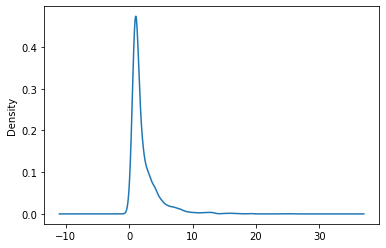

In [11]:
# Visualize the value counts
director_count.plot.density()

In [12]:
# Determine which values to replace
replace_directors = list(director_count[director_count < 10].index)
top_directors = list(director_count[director_count >= 10].index)

# Replace in DataFrame
for director in replace_directors:
    moviedata_df.director_name = moviedata_df.director_name.replace(director,"with_less_movies")
    #produced_less_movies are directors with less than 10 movies in this dataset
for director in top_directors:
    moviedata_df.director_name = moviedata_df.director_name.replace(director,"with_more_movies")
    #produced_more_movies are directors with more than 10 movies in the dataset

# Check to make sure binning was successful
moviedata_df.director_name.value_counts()

C:\Users\Dell inspiron 13\anaconda3\envs\PythonData\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


with_less_movies    3465
with_more_movies     425
Name: director_name, dtype: int64

In [13]:
# Create the OneHotEncoder instance
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(moviedata_df.director_name.values.reshape(-1,1)))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(['director_name'])
encode_df

,director_name_with_less_movies,director_name_with_more_movies
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
3885,1.0,0.0
3886,1.0,0.0
3887,0.0,1.0
3888,1.0,0.0


In [14]:
moviedata_df

,director_name,num_critic_for_reviews,budget,gross,imdb_score
0,with_less_movies,723.0,237000000.0,760505847.0,7.9
1,with_less_movies,302.0,300000000.0,309404152.0,7.1
2,with_less_movies,602.0,245000000.0,200074175.0,6.8
3,with_less_movies,813.0,250000000.0,448130642.0,8.5
5,with_less_movies,462.0,263700000.0,73058679.0,6.6
...,...,...,...,...,...
5033,with_less_movies,143.0,7000.0,424760.0,7.0
5034,with_less_movies,35.0,7000.0,70071.0,6.3
5035,with_more_movies,56.0,7000.0,2040920.0,6.9
5037,with_less_movies,14.0,9000.0,4584.0,6.4


In [15]:
# Generate our categorical variable list
moviedata_cat = moviedata_df.dtypes[moviedata_df.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
moviedata_df[moviedata_cat].nunique()

director_name    2
dtype: int64

In [16]:
# Merge one-hot encoded features and drop the originals
moviedata_df = moviedata_df.merge(encode_df,left_index=True, right_index=True)
moviedata_df = moviedata_df.drop(moviedata_cat,1)
moviedata_df.head()

,num_critic_for_reviews,budget,gross,imdb_score,director_name_with_less_movies,director_name_with_more_movies
0,723.0,237000000.0,760505847.0,7.9,1.0,0.0
1,302.0,300000000.0,309404152.0,7.1,1.0,0.0
2,602.0,245000000.0,200074175.0,6.8,1.0,0.0
3,813.0,250000000.0,448130642.0,8.5,1.0,0.0
5,462.0,263700000.0,73058679.0,6.6,0.0,1.0


In [17]:
# Remove director_name target from features data
y = moviedata_df.director_name_with_more_movies
X = moviedata_df.drop(columns=["director_name_with_more_movies","director_name_with_less_movies"])

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [18]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.881


In [19]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

In [20]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
78/78 [==============================] - 1s 1ms/step - loss: 0.4380 - accuracy: 0.8857
Epoch 2/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3635 - accuracy: 0.8877
Epoch 3/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3532 - accuracy: 0.8877
Epoch 4/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3488 - accuracy: 0.8877
Epoch 5/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3463 - accuracy: 0.8877
Epoch 6/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3446 - accuracy: 0.8877
Epoch 7/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3430 - accuracy: 0.8877
Epoch 8/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3420 - accuracy: 0.8877
Epoch 9/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3411 - accuracy: 0.8877
Epoch 10/50
78/78 [==============================] - 0s 1ms/step - loss: 0.3405 - accuracy: 0.8877
Epoch 11/50
78/78 [